In [1]:
import requests
import numpy as np
import json
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
df = pd.read_csv("AB_NYC_2019.csv")  #Loading in the csv file into a Pandas Data Frame
df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [3]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [4]:
df.shape

(48895, 16)

In [5]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [6]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


## Data Cleaning

In [7]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [8]:
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
df.dropna(subset = ["last_review"], how = "any", inplace = True)  #removing all null values
df.shape

(38843, 16)

In [10]:
df.isnull().sum()  #checking to see if the data frame was reduced in size after dropping the NaN values

id                                 0
name                               6
host_id                            0
host_name                         16
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
dtype: int64

In [11]:
df.drop(['id','host_name'], axis=1, inplace=True)

In [12]:
df.fillna({'reviews_per_month':0}, inplace=True)

In [13]:
df.reviews_per_month.isnull().sum()

0

In [14]:
df.isnull().sum()

name                              6
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [15]:
df.info

<bound method DataFrame.info of                                                    name    host_id  \
0                    Clean & quiet apt home by the park       2787   
1                                 Skylit Midtown Castle       2845   
3                       Cozy Entire Floor of Brownstone       4869   
4      Entire Apt: Spacious Studio/Loft by central park       7192   
5             Large Cozy 1 BR Apartment In Midtown East       7322   
...                                                 ...        ...   
48782        Lovely Privet Bedroom with Privet Restroom   83554966   
48790                          No.2 with queen size bed  257683179   
48799                                   Seas The Moment  211644523   
48805                     1B-1B apartment near by Metro  273841667   
48852           Cozy Private Room in Bushwick, Brooklyn   74162901   

      neighbourhood_group    neighbourhood  latitude  longitude  \
0                Brooklyn       Kensington  40.64749  -73.97

In [16]:
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [17]:
df.neighbourhood_group.unique() #checking unique neighborhood groups

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

In [18]:
df.neighbourhood.unique() #checking unique neighborhoods

array(['Kensington', 'Midtown', 'Clinton Hill', 'East Harlem',
       'Murray Hill', 'Bedford-Stuyvesant', "Hell's Kitchen",
       'Upper West Side', 'Chinatown', 'South Slope', 'West Village',
       'Williamsburg', 'Fort Greene', 'Chelsea', 'Crown Heights',
       'Park Slope', 'Windsor Terrace', 'Inwood', 'East Village',
       'Harlem', 'Greenpoint', 'Bushwick', 'Lower East Side',
       'Prospect-Lefferts Gardens', 'Long Island City', 'Kips Bay',
       'SoHo', 'Upper East Side', 'Prospect Heights',
       'Washington Heights', 'Woodside', 'Flatbush', 'Brooklyn Heights',
       'Carroll Gardens', 'Gowanus', 'Flatlands', 'Cobble Hill',
       'Flushing', 'Boerum Hill', 'Sunnyside', 'DUMBO', 'St. George',
       'Highbridge', 'Financial District', 'Ridgewood',
       'Morningside Heights', 'Jamaica', 'Middle Village', 'NoHo',
       'Ditmars Steinway', 'Flatiron District', 'Roosevelt Island',
       'Greenwich Village', 'Little Italy', 'East Flatbush',
       'Tompkinsville', 'Asto

In [19]:
df.room_type.unique() #checking unique room types

array(['Private room', 'Entire home/apt', 'Shared room'], dtype=object)

## Feature Engineering

In [20]:
location_coord = np.array(list(zip(df.latitude, df.longitude)))
location_coord

array([[ 40.64749, -73.97237],
       [ 40.75362, -73.98377],
       [ 40.68514, -73.95976],
       ...,
       [ 40.54179, -74.14275],
       [ 40.80787, -73.924  ],
       [ 40.69805, -73.92801]])

In [21]:
df["neighbourhood_group"].value_counts()

Manhattan        16632
Brooklyn         16447
Queens            4574
Bronx              876
Staten Island      314
Name: neighbourhood_group, dtype: int64

In [22]:
df["neighbourhood"].value_counts()

Williamsburg                  3163
Bedford-Stuyvesant            3141
Harlem                        2206
Bushwick                      1944
Hell's Kitchen                1532
                              ... 
Castleton Corners                2
Bay Terrace, Staten Island       2
Rossville                        1
Willowbrook                      1
Richmondtown                     1
Name: neighbourhood, Length: 218, dtype: int64

In [23]:
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


In [24]:
#sns.pairplot(df)

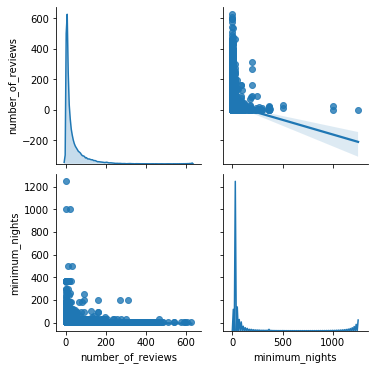

In [25]:
pair_plot= ['neighbourhood_group','number_of_reviews','minimum_nights', 'room_type']
sns.pairplot(df[pair_plot],  kind="reg", diag_kind = "kde"   )
plt.show()

In [26]:
df_corr_matrix = df.corr() 
df_corr_matrix  #computed a correlation matrix for data set to see if it suggested that any features were collinear

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
host_id,1.000000,0.012946,0.141095,0.006269,-0.051693,-0.141819,0.296417,0.149412,0.155082
latitude,0.012946,1.000000,0.088152,0.031318,0.024808,-0.008746,-0.010142,0.004326,-0.022228
longitude,0.141095,0.088152,1.000000,-0.155361,-0.055418,0.054681,0.145948,-0.093325,0.102540
price,0.006269,0.031318,-0.155361,1.000000,0.025506,-0.035938,-0.030608,0.052903,0.078234
minimum_nights,-0.051693,0.024808,-0.055418,0.025506,1.000000,-0.069368,-0.121702,0.073479,0.101686
number_of_reviews,-0.141819,-0.008746,0.054681,-0.035938,-0.069368,1.000000,0.549868,-0.059784,0.193557
reviews_per_month,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791
calculated_host_listings_count,0.149412,0.004326,-0.093325,0.052903,0.073479,-0.059784,-0.009421,1.000000,0.182911
availability_365,0.155082,-0.022228,0.102540,0.078234,0.101686,0.193557,0.185791,0.182911,1.000000


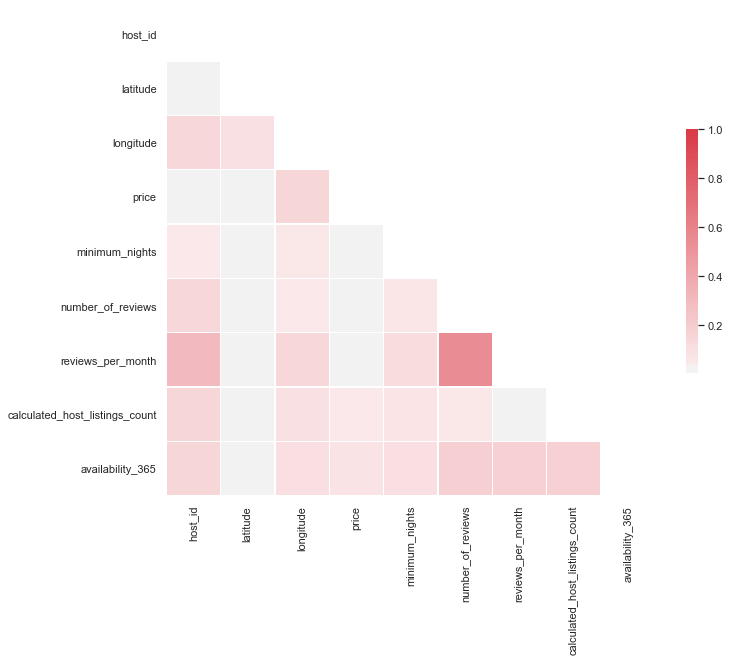

In [27]:
sns.set(style="white")  #using a heat map to display the visuals for the correlations in the dataset
# Compute the correlation matrix
corr = np.abs(df.corr())
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = .5, cbar_kws = {"shrink": .5})

In [28]:
df["price"].unique()   #checked to see how many outlier rows there were


array([  149,   225,    89,    80,   200,    60,    79,   150,   135,
          85,   120,   140,   215,    99,   299,   130,   110,    44,
         180,    50,    52,    55,    70,    40,    68,   115,   151,
         228,   144,    69,    49,   375,   250,   275,   230,    51,
          65,   105,   190,    95,   145,   285,    94,   800,   131,
          98,   100,   125,   175,   500,   101,   220,    59,   350,
         199,   325,   235,   170,   400,    75,    90,   185,    77,
          76,   160,   195,   156,   219,   475,   165,   196,    83,
         123,   265,   249,   121,    45,    71,    64,   159,   189,
         239,   305,   155,    92,    36,    37,   205,    39,   390,
         129,   212,   124,   122,   109,   575,   229,   169,   113,
         179,   349,   139,    67,   599,   211,   290,   395,   260,
          97,   132,   141,   495,   259,    96,   295,   451,   300,
          42,   255,    72,    88,   450,   198,    46,    33,    91,
        2000,   429,

In [29]:
df[df["price"] == 10000]  #checked to see how many outlier rows there were


,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
9151,Furnished room in Astoria apartment,20582832,Queens,Astoria,40.7681,-73.91651,Private room,10000,100,2,2016-02-13,0.04,1,0
17692,Luxury 1 bedroom apt. -stunning Manhattan views,5143901,Brooklyn,Greenpoint,40.7326,-73.95739,Entire home/apt,10000,5,5,2017-07-27,0.16,1,0


In [30]:
df.drop([9151, 17692], axis = 0, inplace = True)  #dropping outliers


In [31]:
df[df["price"] == 10000]  #double checking to see if outliers were officially removed


,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [41]:
df2 = df[df["price"] < 500]


In [33]:
#sns.distplot(df2.price).set_title('AirBnB') #checked to see the skewness of target variable of price


In [34]:
df.sort_values("price", ascending = False).head(10)


,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
6530,Spanish Harlem Apt,1235070,Manhattan,East Harlem,40.79264,-73.93898,Entire home/apt,9999,5,1,2015-01-02,0.02,1,0
12342,"Quiet, Clean, Lit @ LES & Chinatown",3906464,Manhattan,Lower East Side,40.71355,-73.98507,Private room,9999,99,6,2016-01-01,0.14,1,83
30268,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,18128455,Manhattan,Tribeca,40.72197,-74.00633,Entire home/apt,8500,30,2,2018-09-18,0.18,1,251
4377,Film Location,1177497,Brooklyn,Clinton Hill,40.69137,-73.96723,Entire home/apt,8000,1,1,2016-09-15,0.03,11,365
45666,Gem of east Flatbush,262534951,Brooklyn,East Flatbush,40.65724,-73.92450,Private room,7500,1,8,2019-07-07,6.15,2,179
3537,UWS 1BR w/backyard + block from CP,2151325,Manhattan,Upper West Side,40.77782,-73.97848,Entire home/apt,6000,14,17,2015-02-17,0.27,1,359
43009,Midtown Manhattan great location (Gramacy park),16105313,Manhattan,Midtown,40.74482,-73.98367,Entire home/apt,5100,30,1,2019-06-22,1.00,2,343
4345,NearWilliamsburg bridge 11211 BK,14908606,Brooklyn,Bedford-Stuyvesant,40.69572,-73.95731,Private room,5000,6,10,2016-01-02,0.16,1,363
25825,Fulton 2,100069033,Brooklyn,Cypress Hills,40.68185,-73.88128,Entire home/apt,5000,2,4,2018-01-03,0.18,1,0
26739,Broadway 1,153497815,Brooklyn,Bedford-Stuyvesant,40.68742,-73.91957,Entire home/apt,5000,2,8,2017-12-09,0.38,1,0


In [35]:
df.shape

(38841, 14)

In [36]:
df.price.describe()

count    38841.000000
mean       141.810355
std        183.808360
min          0.000000
25%         69.000000
50%        101.000000
75%        170.000000
max       9999.000000
Name: price, dtype: float64

In [37]:
neighbourhood_g = pd.get_dummies(df.neighbourhood_group).iloc[:, 1:]  #creating dummies for categorical variables
room_t = pd.get_dummies(df.room_type).iloc[:, 1:]

df = pd.concat([df, neighbourhood_g, room_t], axis = 1)  #concatting dummies into original Data Frame

In [38]:
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,Brooklyn,Manhattan,Queens,Staten Island,Private room,Shared room
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,1,0,0,0,1,0
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,0,1,0,0,0,0
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,1,0,0,0,0,0
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,0,1,0,0,0,0
5,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129,0,1,0,0,0,0


## Data Visualization

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

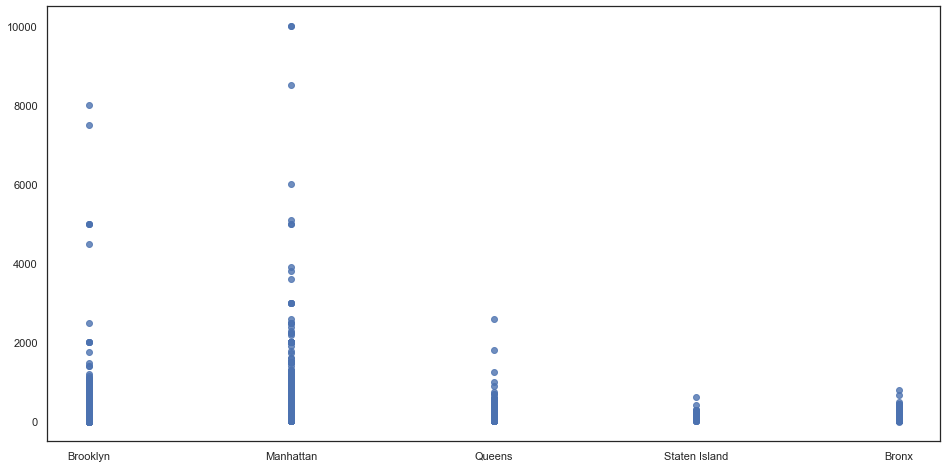

In [48]:
data = df[['price','neighbourhood_group']]
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.regplot(x='neighbourhood_group', y="price", data=data)
plt.title('Price vs Neighborhood Group')

In [44]:
figure,ax = plt.hist(figsize=(10,10))  #boxplot of price & neighborhood groups
sns.boxplot(x = "neighbourhood_group", y = "price", data = df2).set_title("AirBnb")
plt.savefig('Box_NGroup.png')

TypeError: hist() missing 1 required positional argument: 'x'


Shows that price is influenced by the borough the Airbnb is located in; Manhattan having the highest average of price.

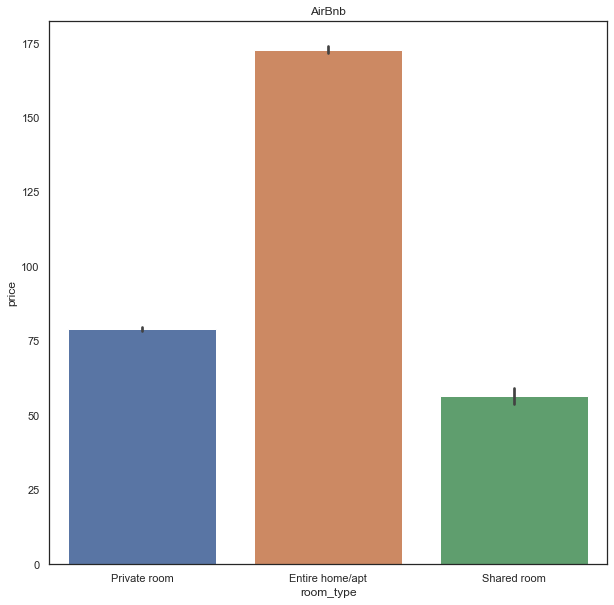

In [43]:
figure,ax = plt.subplots(figsize=(10,10))  #bar graph of price & room types
sns.barplot(x = "room_type", y = "price", data = df2).set_title("AirBnb")
plt.savefig('Bar_Room.png')

Shows that Entire home/apt room type offers the highest price

## Hypothesis Testing

H0: There is no difference between the means of price and the neighborhood groups HA: There is a difference between the means of price and the neighborhood groups

In [ ]:
stats.f_oneway(df["price"][df['neighbourhood_group'] == 'Manhattan'],
                df['price'][df['neighbourhood_group'] == 'Brooklyn'], 
                df['price'][df['neighbourhood_group'] == 'Queens'])


H0: There is no difference between the means of price and the room types HA: There is a difference between the means of price and the room types

In [ ]:
stats.f_oneway(df["price"][df['room_type'] == 'Entire home/apt'],
                df['price'][df['room_type'] == 'Private room'], 
                df['price'][df['room_type'] == 'Shared room'])

Based on the P-Value, I can reject the null hypothesis